In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

## 1. Load LOB data (resampled to 1 minute)

In [2]:
lob_data=pd.read_csv('../datasets/resampled_lob_minALL.csv')
# lob_data['Datetime'] = pd.to_datetime(lob_data['Datetime'])
# lob_data.set_index('Datetime', inplace=True)
lob_data

,Datetime,Min Ask Price,Max Bid Price,Total Bid Quantity,Total Ask Quantity,Min Ask Quantity,Max Bid Quantity
0,2025-01-02 00:00:00,271.841538,260.186154,22881.0,16799.0,3,5
1,2025-01-02 00:01:00,262.803138,258.206847,24821.0,12978.0,2,3
2,2025-01-02 00:02:00,267.596615,262.929478,33966.0,11786.0,2,3
3,2025-01-02 00:03:00,267.066274,262.751105,30396.0,15613.0,3,2
4,2025-01-02 00:04:00,268.358289,263.077540,28408.0,16458.0,3,4
...,...,...,...,...,...,...,...
62853,2025-07-01 08:13:00,151.230132,96.942053,18271.0,10399.0,3,4
62854,2025-07-01 08:14:00,200.771852,107.148148,16849.0,10211.0,2,3
62855,2025-07-01 08:15:00,174.894172,107.539877,29053.0,9511.0,2,4
62856,2025-07-01 08:16:00,174.897866,108.716463,33890.0,9471.0,2,6


## 2. Feature Engineering
### 1. Calculate the weighted average price
Use the following formula to calculate the weighted average price:
$$\[
\text{Weighted Average Price} = \frac{\text{Max Bid Price} \times \text{Max Bid Quantity} + \text{Min Ask Price} \times \text{Min Ask Quantity}}{\text{Max Bid Quantity} + \text{Min Ask Quantity}}
\]$$


In [3]:
# calculate a weighted average of the bid and ask prices
lob_data['price'] = (lob_data['Max Bid Price']* lob_data['Max Bid Quantity'] + lob_data['Min Ask Price'] * lob_data['Min Ask Quantity']) / (lob_data['Max Bid Quantity'] + lob_data['Min Ask Quantity'])
lob_data['spread'] = lob_data['Min Ask Price'] - lob_data['Max Bid Price']
# lob_data

### 2. OFI (Order Flow Imbalance)
reference: [Order Flow Imbalance](https://github.com/nicolezattarin/LOB-feature-analysis)

<img src="../imgs/img.png">

where b_m(t) and a_m(t) are respectively bid and ask prices at level m at time t and r_m(t) and q_m(t) are the corresponding volumes.
The OFI is calculated as follows:
$$\( e^m(t_n) = \Delta W^m(t_n) - \Delta V^m(t_n) \)$$

In [4]:
def calculate_ofi(df):
    df['delta_bid'] = df['Max Bid Price'].diff().fillna(0)
    df['delta_ask'] = df['Min Ask Price'].diff().fillna(0)
    
        # 计算 ΔW^m(t_n)
    df['delta_w'] = df.apply(
        lambda row: row['Max Bid Quantity'] if row['delta_bid'] > 0 else
                   (-row['Max Bid Quantity'] if row['delta_bid'] < 0 else
                    row['Max Bid Quantity'] - df.loc[df.index[df.index.get_loc(row.name)-1], 'Max Bid Quantity']
                    if row.name > 0 else 0),
        axis=1)
    
    # 计算 ΔV^m(t_n)
    df['delta_v'] = df.apply(
        lambda row: -row['Min Ask Quantity'] if row['delta_ask'] > 0 else
                   (row['Min Ask Quantity'] if row['delta_ask'] < 0 else
                    row['Min Ask Quantity'] - df.loc[df.index[df.index.get_loc(row.name)-1], 'Min Ask Quantity']
                    if row.name > 0 else 0),
        axis=1)
    
    # 计算 OFI
    df['ofi'] = df['delta_w'] + df['delta_v']
    
    return df['ofi']

calculate_ofi(lob_data)
lob_data=lob_data[['Datetime','Min Ask Price','Max Bid Price','price','Total Bid Quantity','Total Ask Quantity','Min Ask Quantity','Max Bid Quantity','ofi','spread']]
# drop the first row (ofi is 0)
lob_data = lob_data.iloc[1:]
lob_data

,Datetime,Min Ask Price,Max Bid Price,price,Total Bid Quantity,Total Ask Quantity,Min Ask Quantity,Max Bid Quantity,ofi,spread
1,2025-01-02 00:01:00,262.803138,258.206847,260.045364,24821.0,12978.0,2,3,-1,4.596291
2,2025-01-02 00:02:00,267.596615,262.929478,264.796333,33966.0,11786.0,2,3,1,4.667137
3,2025-01-02 00:03:00,267.066274,262.751105,265.340206,30396.0,15613.0,3,2,1,4.315169
4,2025-01-02 00:04:00,268.358289,263.077540,265.340718,28408.0,16458.0,3,4,1,5.280749
5,2025-01-02 00:05:00,265.378682,260.562412,262.167835,28895.0,12759.0,2,4,-2,4.816269
...,...,...,...,...,...,...,...,...,...,...
62853,2025-07-01 08:13:00,151.230132,96.942053,120.208373,18271.0,10399.0,3,4,-1,54.288079
62854,2025-07-01 08:14:00,200.771852,107.148148,144.597630,16849.0,10211.0,2,3,1,93.623704
62855,2025-07-01 08:15:00,174.894172,107.539877,129.991309,29053.0,9511.0,2,4,6,67.354294
62856,2025-07-01 08:16:00,174.897866,108.716463,125.261814,33890.0,9471.0,2,6,4,66.181402


### 3. Time Features

In [5]:
lob_data['Datetime'] = pd.to_datetime(lob_data['Datetime'])
lob_data['Hour'] = lob_data['Datetime'].dt.hour
lob_data['Dayofweek'] = lob_data['Datetime'].dt.dayofweek
lob_data['Day'] = lob_data['Datetime'].dt.day
lob_data['Month'] = lob_data['Datetime'].dt.month

### 4. Relative Strength Index (RSI)

In [6]:
def calculate_rsi(data, window):
    """
    计算给定数据的相对强弱指数（RSI）。
    
    :param data: 包含价格数据的Pandas Series。
    :param window: 用于计算RSI的窗口大小，默认为14。
    :return: 包含RSI值的Pandas Series。
    """
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()

    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# 计算Min Ask Price的RSI
lob_data['RSI'] = calculate_rsi(lob_data['price'], window=5)

### 5. Volatility
Use volatility to adjust the trading quantity. The volatility is calculated as the standard deviation of the log returns of the price.

When considering `scaler_factor`, we should use the ask/bid volatility to adjust it. I found that the ask volatility is much larger than the bid volatility in TEST data. So when we use the test data to do backtesting, we should use 20 as the scaler factor for the ask volatility and 10 as the scaler factor for the bid volatility.

In [7]:
# # 设置一个时间窗口
rolling_window = 5  # 例如，我们使用过去5个时间点的数据来计算波动率

# 计算对数收益率 shift(1)是为了计算相对于前一分钟的收益率
lob_data['Log Return Max Bid'] = np.log(lob_data['Max Bid Price'] / lob_data['Max Bid Price'].shift(1))
lob_data['Log Return Min Ask'] = np.log(lob_data['Min Ask Price'] / lob_data['Min Ask Price'].shift(1))

# 计算滚动标准差作为波动率的度量
lob_data['Volatility Max Bid'] = lob_data['Log Return Max Bid'].rolling(window=rolling_window).std()
lob_data['Volatility Min Ask'] = lob_data['Log Return Min Ask'].rolling(window=rolling_window).std()

# 由于滚动计算会产生缺失值，我们通常会删除这些值
lob_data.dropna(inplace=True)

In [8]:
# Trading volume
def adjust_trade_quantity(volatility, max_tradeable_quantity, base_quantity=1, risk_tolerance=0.5, scaler_fator=10):
    """
    根据波动率和最大可交易量调整交易量。
    volatility: 当前波动率
    max_tradeable_quantity: 该时间点的最大可交易量（对于买入操作，是Min Ask Quantity；对于卖出操作，是Max Bid Quantity）
    base_quantity: 基础交易量
    risk_tolerance: 风险容忍度，取值范围为[0, 1]，数值越小表风险承受越大，交易量越大
    """
    # 基于波动率调整的交易量
    adjusted_quantity = base_quantity / (volatility*risk_tolerance*scaler_fator)
    adjusted_quantity = max(1, round(adjusted_quantity))  # 确保至少交易1单位，并且是整数

    # 确保交易量不超过最大可交易量 make sure the trade quantity is no more than the max tradeable quantity
    final_trade_quantity = min(adjusted_quantity, max_tradeable_quantity)

    return final_trade_quantity

In [9]:
# test the adjust_trade_quantity function on TEST data
split_index=int(len(lob_data)*0.8) # 50280
for i in range(20):
    current_volatility_buy = lob_data['Volatility Min Ask'].iloc[i+split_index]
    current_volatility_sell = lob_data['Volatility Max Bid'].iloc[i+split_index]
    max_tradeable_quantity_buy = lob_data['Min Ask Quantity'].iloc[i+split_index]
    max_tradeable_quantity_sell = lob_data['Max Bid Quantity'].iloc[i+split_index]
    print('Time:',lob_data['Datetime'].iloc[i+split_index])
    print('buy:',adjust_trade_quantity(current_volatility_buy, max_tradeable_quantity_buy, base_quantity=1, risk_tolerance=0.5, scaler_fator=10),'Max Ask Quantity:',max_tradeable_quantity_buy    )
    print('sell:',adjust_trade_quantity(current_volatility_sell, max_tradeable_quantity_sell, base_quantity=1, risk_tolerance=0.5, scaler_fator=20),'Max Bid Quantity:',max_tradeable_quantity_sell)

Time: 2025-05-28 00:20:00
buy: 2 Max Ask Quantity: 3
sell: 3 Max Bid Quantity: 5
Time: 2025-05-28 00:21:00
buy: 1 Max Ask Quantity: 3
sell: 2 Max Bid Quantity: 4
Time: 2025-05-28 00:22:00
buy: 1 Max Ask Quantity: 2
sell: 3 Max Bid Quantity: 3
Time: 2025-05-28 00:23:00
buy: 1 Max Ask Quantity: 3
sell: 4 Max Bid Quantity: 4
Time: 2025-05-28 00:24:00
buy: 1 Max Ask Quantity: 3
sell: 4 Max Bid Quantity: 5
Time: 2025-05-28 00:25:00
buy: 1 Max Ask Quantity: 2
sell: 5 Max Bid Quantity: 5
Time: 2025-05-28 00:26:00
buy: 1 Max Ask Quantity: 2
sell: 2 Max Bid Quantity: 3
Time: 2025-05-28 00:27:00
buy: 2 Max Ask Quantity: 2
sell: 2 Max Bid Quantity: 3
Time: 2025-05-28 00:28:00
buy: 2 Max Ask Quantity: 2
sell: 2 Max Bid Quantity: 4
Time: 2025-05-28 00:29:00
buy: 2 Max Ask Quantity: 2
sell: 2 Max Bid Quantity: 4
Time: 2025-05-28 00:30:00
buy: 3 Max Ask Quantity: 3
sell: 2 Max Bid Quantity: 5
Time: 2025-05-28 00:31:00
buy: 1 Max Ask Quantity: 3
sell: 2 Max Bid Quantity: 3
Time: 2025-05-28 00:32:00
bu

### 6. Generate labels for the classification task
Use `price` column to calculate the price difference between the current time point and the next time point. 

We can see the `price_diff` is a normal distribution. We can use mean+/-std as the threshold to generate the labels. 

count    62851.000000
mean        -0.002029
std         10.878994
min        -57.313045
25%         -6.181781
50%         -0.147865
75%          6.125863
max         65.678323
Name: price_diff, dtype: float64


E:\Programming\anaconda3\envs\mytorch\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='price_diff', ylabel='Count'>

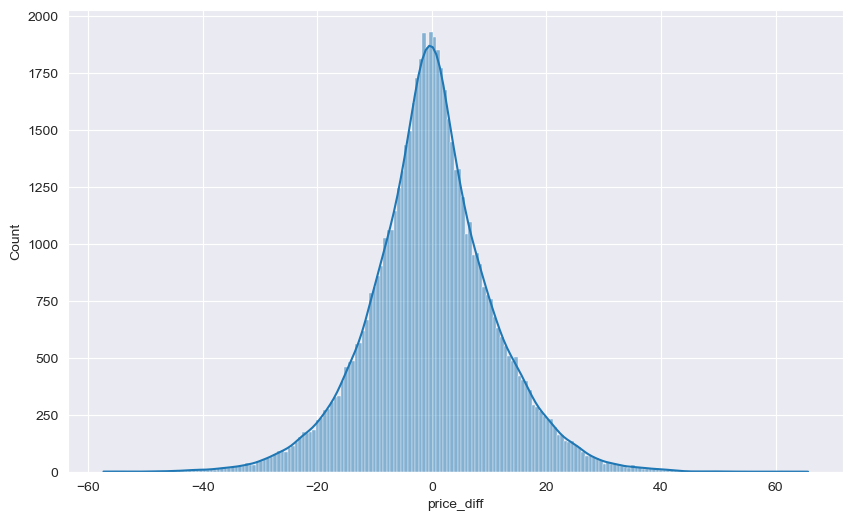

In [10]:
# 计算price与下一个时间点的price的差值
lob_data['price_diff'] = lob_data['price'].diff().shift(-1)
print(lob_data['price_diff'].describe())
# 绘制pricediff的分布
plt.figure(figsize=(10, 6))
sns.histplot(lob_data['price_diff'], kde=True)

The statistics you provided show that the distribution of `price_diff` has some normal distribution properties. Based on this property, we can use the standard deviation of `price_diff` to define a threshold for categorizing price changes. In a normal distribution, about 68% of the data will fall within the mean plus or minus one standard deviation, about 95% of the data will fall within the mean plus or minus two standard deviations, and almost all of the data (99.7%) will fall within the mean plus or minus three standard deviations.

Using this property, we can define multiple classifications, for example:
- `Basically unchanged`: changes within `mean ± 0.5 *  std` are defined as basically unchanged (category 0).
- `Small increase/decrease`: an increase/decrease of more than 0.5 standard deviations but not more than 1 standard deviation is defined as a small change (increase category 1/decrease category -1).
- `Medium rise/decline`: rises/declines of more than 1 standard deviation but not more than 2 standard deviations are defined as medium movements (rise category 2/decline category -2).
- `Massive rise/fall`: rises/falls of more than 2 standard deviations are defined as large movements (rise category 3/fall category -3).

Now, let's generate labels based on this logic. To make things easier, I will first calculate the mean and standard deviation of `price_diff`. Then, we will define the categorization thresholds for price changes based on these statistics and the distributional properties you provided and generate the corresponding labels.

Multi-categorical labels have been generated based on the statistics you provided and the properties of the normal distribution. The labels have been categorized into the following categories based on the range of price changes:

- `0`: essentially unchanged, with price changes within ±0.5 standard deviations of the mean.
- `1`: small increase, with price changes of more than 0.5 standard deviations but not more than 1 standard deviation.
- `2`: medium increase, with price changes of more than 1 standard deviation but not more than 2 standard deviations.
- `3`: a large increase, with a price change of more than 2 standard deviations.
- `-1`: small decrease, ibid.
- `-2`: medium decrease, id.
- `-3`: large decrease, ditto.

Based on the generated distribution of labels, the vast majority of price changes in the data are categorized as essentially unchanged (0), which is consistent with the properties of a normal distribution, indicating that most price changes are concentrated around the mean. The other categories are decreasing in number, indicating that there are fewer large price changes, which is also consistent with the long-tailed nature of the normal distribution.


In [11]:
mean_diff= lob_data['price_diff'].mean() # -0.002
std_diff= lob_data['price_diff'].std() # 10.87

# create thresholds based on the mean and std of price_diff
thresholds = [mean_diff - 0.5 * std_diff, mean_diff + 0.5 * std_diff,
              mean_diff - 1 * std_diff, mean_diff + 1 * std_diff,
              mean_diff - 2 * std_diff, mean_diff + 2 * std_diff]

# generate labels based on the thresholds
def generate_multi_labels(price_diff, thresholds):
    if thresholds[0] < price_diff <= thresholds[1]:
        return 0
    elif thresholds[1] < price_diff <= thresholds[3]:
        return 1
    elif thresholds[3] < price_diff <= thresholds[5]:
        return 2
    elif price_diff > thresholds[5]:
        return 3
    elif thresholds[0] > price_diff >= thresholds[2]:
        return -1
    elif thresholds[2] > price_diff >= thresholds[4]:
        return -2
    elif price_diff < thresholds[4]:
        return -3
    
def generate_binary_labels(price_diff, thresholds):
    if price_diff > thresholds[1]:
        return 1
    elif price_diff < thresholds[0]:
        return -1
    else:
        return 0
    
lob_data['label'] = lob_data['price_diff'].apply(generate_multi_labels, args=(thresholds,))
# 0.0,28712
# -1.0,8703
# 1.0,8103
# 2.0,7023
# -2.0,6747
# 3.0,1811
# -3.0,1752

lob_data['label_binary'] = lob_data['price_diff'].apply(generate_binary_labels, args=(thresholds,)) # [0: 17202; 1: 16937]

您提供的统计数据显示，`price_diff`的分布具有一定的正态分布特性。基于这个特性，我们可以使用`price_diff`的标准差来定义价格变动的分类阈值。在正态分布中，大约68%的数据会落在均值加减一个标准差之内，大约95%的数据会落在均值加减两个标准差之内，几乎所有的数据（99.7%）会落在均值加减三个标准差之内。

利用这个特性，我们可以定义多个分类，比如：
- `基本不变`：在`mean ± 0.5 * std`范围内的变动定义为基本不变（0类）。
- `小幅上升/下降`：超过0.5个标准差但不超过1个标准差的上升/下降定义为小幅变动（上升1类/下降-1类）。
- `中幅上升/下降`：超过1个标准差但不超过2个标准差的上升/下降定义为中幅变动（上升2类/下降-2类）。
- `大幅上升/下降`：超过2个标准差的上升/下降定义为大幅变动（上升3类/下降-3类）。

现在，让我们基于这个逻辑生成标签。为了便于操作，我会首先计算`price_diff`的均值和标准差。然后，我们将基于这些统计数据和您提供的分布特性来定义价格变动的分类阈值，并生成相应的标签。

已经根据您提供的统计数据和正态分布的性质生成了多分类标签。根据价格变动的范围，标签被分为以下几类：

- `0`：基本不变，价格变动在均值±0.5个标准差内。
- `1`：小幅上升，价格变动超过0.5个标准差但不超过1个标准差。
- `2`：中幅上升，价格变动超过1个标准差但不超过2个标准差。
- `3`：大幅上升，价格变动超过2个标准差。
- `-1`：小幅下降，同上。
- `-2`：中幅下降，同上。
- `-3`：大幅下降，同上。

根据生成的label分布，绝大部分数据的价格变动被分类为基本不变（0），这与正态分布的特性相符，表明大多数价格变动都集中在均值附近。其他类别的数量逐渐递减，表明大幅度的价格变动较少，这也符合正态分布的长尾性质。

## 3. Classification
### 3.1 Random Forest



In [12]:
# split the data into training and testing sets
data_rf=lob_data.copy()
data_rf.dropna(inplace=True)
split_index=int(len(data_rf)*0.8) # 50280

# X=data_rf[['Min Ask Price','Max Bid Price','price','Total Bid Quantity','Total Ask Quantity','Min Ask Quantity','Max Bid Quantity','ofi','spread','Hour','Dayofweek','Day','Month','RSI','Volatility Max Bid','Volatility Min Ask']]
X=data_rf[['Min Ask Price','Max Bid Price','price','Total Bid Quantity','Total Ask Quantity','Min Ask Quantity','Max Bid Quantity','ofi','Hour','Dayofweek','Day','Month']]
y=data_rf['label_binary']

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [13]:
# # grid search
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [10, 20, 30, 40, 50],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'class_weight': ['balanced']
# }
# 
# rf_clf = RandomForestClassifier(random_state=42)
# grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=5, n_jobs=-1)
# grid_search.fit(X_train, y_train)
# print(grid_search.best_params_)

In [14]:
# random forest
rf_clf= RandomForestClassifier(n_estimators=100, random_state=42,max_depth=15,  min_samples_split=5, class_weight='balanced',n_jobs=-1)
rf_clf.fit(X_train, y_train)
y_pred_train=rf_clf.predict(X_train)
y_pred_test=rf_clf.predict(X_test)
y_pred_all=rf_clf.predict(X)

# classification report
print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))
# print(classification_report(y, y_pred_all))

              precision    recall  f1-score   support

          -1       0.78      0.86      0.81     13303
           0       0.90      0.81      0.85     23936
           1       0.81      0.88      0.84     13041

    accuracy                           0.84     50280
   macro avg       0.83      0.85      0.84     50280
weighted avg       0.84      0.84      0.84     50280

              precision    recall  f1-score   support

          -1       0.87      0.12      0.21      3899
           0       0.26      0.07      0.11      4776
           1       0.36      0.97      0.52      3896

    accuracy                           0.37     12571
   macro avg       0.50      0.39      0.28     12571
weighted avg       0.48      0.37      0.27     12571


## 4. Trading Strategy
### 1.Only use machine learning model to predict the price movement (binary classification)
BUY: prdicion=1 --- price will go up (more than 0.5 std)
SELL: prediction=-1 --- price will go down (more than 0.5 std)
HOLD: prediction=0 --- price will be stable (within 0.5 std)


Profit:  14594
Final return:  14.59 %
Number of trades:  1646



In [35]:
initial_capital = 100000
capital = initial_capital
has_position = False
trade_log = []
# capital_history = [initial_capital]
current_holdings = 0
transaction_cost = 0
# trade_quantity = 1

for i in range(len(X_test)):
    
    # prediction = rf_clf.predict(X_test.iloc[i].values.reshape(1, -1))[0]
    prediction = y_pred_test[i]
    # adjust the trade quantity based on the volatility. make the trade quantity no more than the max tradeable quantity
    current_volatility_buy = lob_data['Volatility Min Ask'].iloc[i+split_index]
    current_volatility_sell = lob_data['Volatility Max Bid'].iloc[i+split_index]
    ofi=lob_data['ofi'].iloc[i+split_index]
    rsi=lob_data['RSI'].iloc[i+split_index]
    
    # buy policy: if the model predicts the ask price will go up, and the current has no position, then buy
    if not has_position and ofi>2:
    # if not has_position and rsi>60:
        
        # buy_price=X_test['price'].iloc[i]
        buy_price = lob_data['price'].iloc[i+split_index]
        buy_quantity = adjust_trade_quantity(current_volatility_buy,lob_data['Min Ask Quantity'].iloc[i+split_index],scaler_fator=10)
        capital -= buy_price*buy_quantity*(1+transaction_cost)
        current_holdings += buy_quantity
        has_position = True
        trade_log.append({'action': 'BUY', 'Time':lob_data['Datetime'].iloc[i+split_index],'price': buy_price, 'capital': capital, 'quantity': buy_quantity,'max quantity':lob_data['Min Ask Quantity'].iloc[i+split_index],'prediction':prediction})
        
    # sell policy: if the model predicts the bid price will go down, and the current has position, then sell
    elif has_position and ofi<-2:
    # elif has_position and rsi<40:
        
        # sell_price=X_test['price'].iloc[i]
        sell_price = lob_data['price'].iloc[i+split_index]
        sell_quantity = min(current_holdings, adjust_trade_quantity(current_volatility_sell,lob_data['Max Bid Quantity'].iloc[i+split_index],scaler_fator=20))
        capital += sell_price*sell_quantity*(1-transaction_cost)
        current_holdings -= sell_quantity
        has_position = False
        trade_log.append({'action': 'SELL','Time':lob_data['Datetime'].iloc[i+split_index],'price': sell_price, 'capital': capital, 'quantity': sell_quantity,'max quantity':lob_data['Max Bid Quantity'].iloc[i+split_index],'prediction':prediction})
        
    # hold policy: if the model predicts the price will not change, and the current has position, then hold
    elif has_position and prediction==0:
        trade_log.append({'action': 'HOLD','Time':lob_data['Datetime'].iloc[i+split_index],'price': lob_data['price'].iloc[i+split_index], 'capital': capital, 'quantity': current_holdings,'max quantity':lob_data['Max Bid Quantity'].iloc[i+split_index],'prediction':prediction})

# 计算最终资本
final_capital = capital
profit = final_capital - initial_capital
# 只计算buy和sell的次数
number_of_trades = len([trade for trade in trade_log if trade['action'] in ['BUY', 'SELL']])
# number_of_trades = len(trade_log)

# 保留两位小数
print('Final capital: ', round(final_capital))
print('Profit: ', round(profit))
print('Final return: ', round(profit / initial_capital * 100, 2), '%')
print('Number of trades: ', number_of_trades)

Final capital:  111863
Profit:  11863
Final return:  11.86 %
Number of trades:  4567
